<a href="https://colab.research.google.com/github/JA4S/JANC/blob/main/examples/2D/Detonation-Tube/2D_detonation_tube.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install JANC and import relevant libraries

In [ ]:
# Copyright © 2025 Haocheng Wen, Faxuan Luo
# SPDX-License-Identifier: MIT

!pip install git+https://github.com/JA4S/JANC.git
!wget https://raw.githubusercontent.com/JA4S/JANC/main/examples/2D/Detonation-Tube/9sp-19r-H2-Air.yaml

In [ ]:
from janc_v2.model import thermo_model
from janc_v2.simulation import set_simulator

import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

# set JAX to use GPU
jax.config.update("jax_enable_x64", True)
jax.config.update('jax_platform_name', 'gpu')

# Example : H2-Air Detonation Tube

# Set grid, thermodynamics, reactions, and flux solver

In [ ]:
Lx = 0.05
Ly = 0.0125

nx = 4000
ny = 1000

dx = Lx/nx
dy = Ly/ny

grid_config = {'dx':dx,'dy':dy}

thermo_config = {'thermo_model':'nasa7',
         'mechanism_directory':'9sp-19r-H2-Air.yaml'
          }
thermo_model.set_thermo(thermo_config)
#reaction_config
reaction_config = {'is_detailed_chemistry':True,
           'mechanism_directory':'9sp-19r-H2-Air.yaml'
          }
#flux_config
flux_config = {'solver_type':'flux_splitting',
        'interface_reconstruction':'WENO5_JS',
        'split_method':'LF',
        'viscosity':'off'
        }

# Set boundary conditions

In [ ]:
boundary_config = {'left_boundary':'slip_wall',
           'right_boundary':'slip_wall',
           'bottom_boundary':'slip_wall',
           'top_boundary':'slip_wall'}

# Initializations

In [ ]:
time_control = {'temporal_evolution_scheme':'TVD_RK3',
         'dt':5e-10,
         't_end':1e-6}
simulation_config = {'dimension':'2D',
            'grid_config':grid_config,
            'thermo_config':thermo_config,
            'reaction_config':reaction_config,
            'flux_config':flux_config,
            'boundary_config':boundary_config,
            'time_config':time_control}
Simulator = set_simulator.Simulator(simulation_config)
#advance_one_step: time advance functions, advance current state one time step dt.
#rhs: right-hand side of the Euler-equations: dUdt = rhs,
#normally, 【advance_one_step is all you need】. However, when it comes to machine-learning tasks,
#rhs can be embedded in a differentiable optimization loop

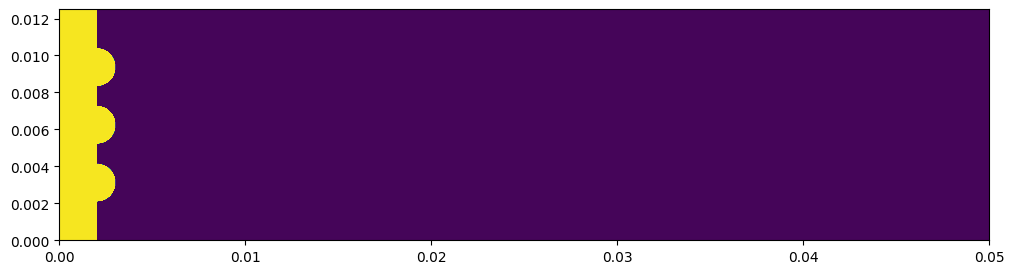

In [ ]:
def initial_conditions():
    #nondimensionalize the pressure and tempreature using P0,T0
    Penv = 1.0*101325; Tenv = 300; yH2env = 0.028; yO2env = 0.226;
    Pignition = 75*101325; Tignition = 3500;
    #set the mass fractions for the species (except inert species N2, which leaves 8 species to set)
    Yenv = jnp.array([yH2env,yO2env,0,0,0,0,0,0])

    #set ignition zone (rectangular shape)
    ignition_width = 160
    ignition_height = ny
    Y_init = jnp.broadcast_to(Yenv[:,None,None],(8,nx,ny))
    T_init = jnp.full((1,nx,ny),Tenv)
    T_init = T_init.at[:,0:ignition_width,0:ignition_height].set(Tignition)
    P_init = jnp.full((1,nx,ny),Penv)
    P_init = P_init.at[:,0:ignition_width,0:ignition_height].set(Pignition)
    #set ignition zone (circle shape)
    temp_x = jnp.linspace(0, nx, nx)
    temp_y = jnp.linspace(0, ny, ny)
    temp_x, temp_y = jnp.meshgrid(temp_y, temp_x)
    radius = ignition_width//2
    #three semicircle ignition zone to induce detonation cells
    distance_1 = jnp.sqrt((temp_y[None,:,:] - ignition_width)**2 + (temp_x[None,:,:] - ignition_height//4)**2)
    distance_2 = jnp.sqrt((temp_y[None,:,:] - ignition_width)**2 + (temp_x[None,:,:] - (ignition_height//4)*2)**2)
    distance_3 = jnp.sqrt((temp_y[None,:,:] - ignition_width)**2 + (temp_x[None,:,:] - (ignition_height//4)*3)**2)
    mask = (distance_1 <= radius) | (distance_2 <= radius) | (distance_3 <= radius)
    T_init = T_init.at[mask].set(Tignition)
    P_init = P_init.at[mask].set(Pignition)
    #get relevant thermo properties from tempreature and species mass fractions
    _,gamma_init,h_init,R_init,_ = thermo_model.get_thermo(T_init,Y_init)

    rho_init = P_init/(R_init*T_init)
    E_init = rho_init*h_init - P_init
    rhou_init = jnp.zeros((1,nx,ny))
    rhov_init = jnp.zeros((1,nx,ny))

    #concatenate the conservative variables U, and thermo variables aux(gamma,T)
    U_init = jnp.concatenate([rho_init,rhou_init,rhov_init,E_init,rho_init*Y_init],axis=0)
    aux_init = jnp.concatenate([gamma_init,T_init],axis=0)
    return U_init, aux_init


U, aux = initial_conditions()
plt.figure(figsize=(12, 3))
x = jnp.linspace(0, Lx, nx)
y = jnp.linspace(0, Ly, ny)
X, Y = jnp.meshgrid(x, y, indexing='ij')

#Tempreature Contour
plt.contourf(X, Y, aux[-1], levels=50, cmap='viridis')

# Main loop of time advance

In [ ]:
U_final, aux_final, t_final = Simulator.run(U,aux)

# plot

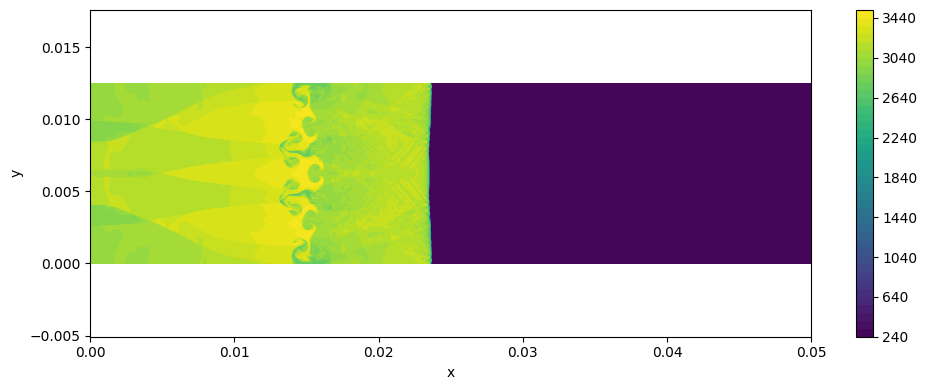

In [ ]:
T = aux_final[-1]
plt.figure(figsize=(12, 3))
plt.contourf(X, Y, T, levels=50, cmap='viridis')
plt.xlabel('x')
plt.ylabel('y')
plt.ylim(0,Ly)
plt.colorbar(label='Temperature (K)')
plt.tight_layout()
plt.axis('equal')
plt.show()